In [1]:
import os
import glob

import DESutils
import GPRutils
import vK2KGPR
import plotGPR
import vK2KGPR
import vonkarmanFT as vk

import numpy as np
import astropy.units as u
import astropy.table as tb
from astropy.time import Time
import matplotlib.pyplot as plt
plt.style.use('~/GitHub/custom-matplotlib/custom.mplstyle')
import astropy.stats as stats
from scipy.signal import savgol_filter

from IPython import embed
from importlib import reload
import warnings
warnings.filterwarnings("ignore")

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [2]:
FITSfiles = sorted(glob.glob(f"/home/fortino/GPRSolutions/zone134/GPR.??????.?RC.fits"))
FITSfiles += sorted(glob.glob(f"/home/fortino/GPRSolutions/zone133/GPR.??????.?RC.fits"))
FITSfiles += sorted(glob.glob(f"/home/fortino/GPRSolutions/zone132/GPR.??????.?RC.fits"))
FITSfiles += sorted(glob.glob(f"/home/fortino/GPRSolutions/eris/GPR.??????.?RC.fits"))
print(len(FITSfiles))

343


In [3]:
%%time
AP = plotGPR.AggregatePlots(FITSfiles)

CPU times: user 104 µs, sys: 22 µs, total: 126 µs
Wall time: 131 µs


In [4]:
%%time
AP.calcVals()

CPU times: user 2min 24s, sys: 7.62 s, total: 2min 32s
Wall time: 3min 7s


[]
[]
[]
[122.74066571]


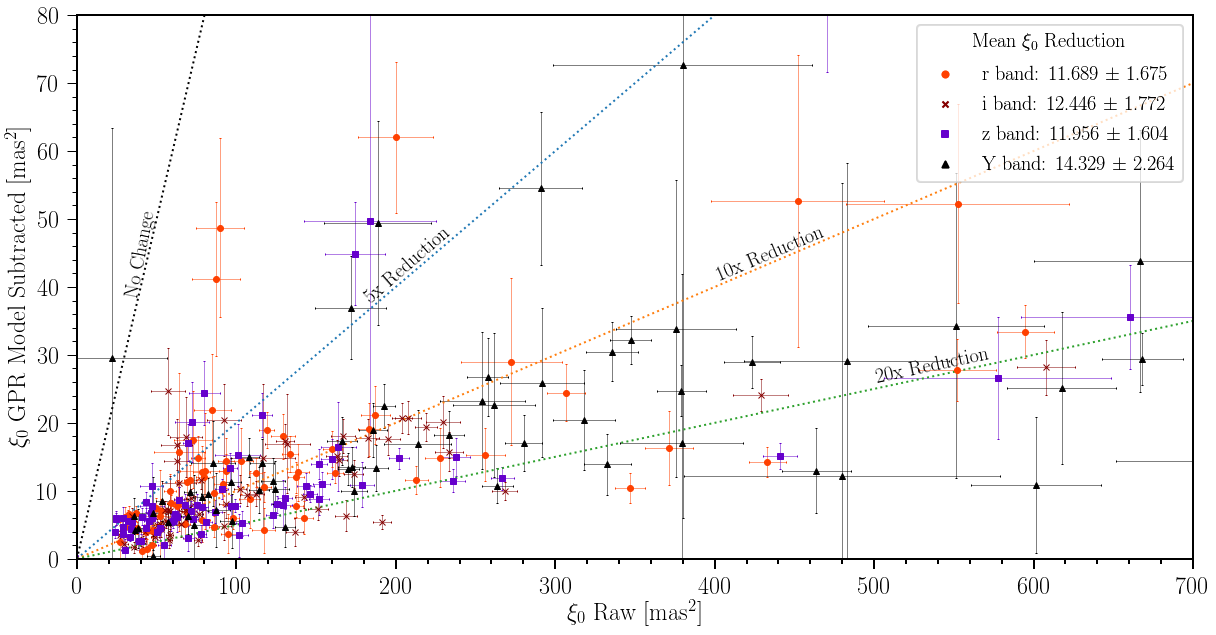

In [5]:
def xiBA(
    AP,
    passband,
    annotate=False,
    xlim=(0, None),
    ylim=(0, None),
    save=None
        ):
    framealpha = 0.5

    fig = plt.figure(figsize=(20, 10))

    bandHandles = []
    for band in plotGPR.DES_PASSBANDS:

        # Check if the current band in the loop is one of the bands in the list passband.
        if band not in passband:
            continue

        # If there are no exposures for that band in AP, then skip it.
        if len(AP.expNums[band]) == 0:
            continue
            
        xi0_raw = AP.xi0_raw[band]
        xi0_GPR = AP.xi0_GPR[band]

        xi0err_raw = AP.xi0err_raw[band]
        xi0err_GPR = AP.xi0err_GPR[band]

        plt.errorbar(
            xi0_raw, xi0_GPR,
            xerr=xi0err_raw, yerr=xi0err_GPR,
            color=plotGPR.DES_COLORS[band],
#             marker=".",
            marker=plotGPR.DES_MARKERS[band],
            ls="",
            linewidth=0.5, capsize=1)
        
#         plt.scatter(
#             xi0_raw, xi0_GPR,
#             color=plotGPR.DES_COLORS[band],
#             marker=".", s=1
# #             marker=plotGPR.DES_MARKERS[band]
#             )

        mask = stats.sigma_clip(AP.red[band], sigma=5).mask
        print(np.array(AP.red[band])[mask])
        avgRed = np.mean(np.array(AP.red[band])[~mask])
        avgRedErr = np.sqrt(np.sum(np.power(np.array(AP.red[band])[~mask], 2)))
        avgRedErr /= len(np.array(AP.red[band])[~mask])

        bandHandle = plt.scatter(
            -1, 0,
            alpha=1,
            color=plotGPR.DES_COLORS[band],
#             marker=".",
            marker=plotGPR.DES_MARKERS[band],
            label=f"{band} band: {avgRed:.3f} ± {avgRedErr:.3f}")
        bandHandles.append(bandHandle)
        
        if annotate:
            for i in range(len(AP.expNums[band])):
                plt.annotate(
                    f"{AP.expNums[band][i]} {band}",
                    (AP.xi0_raw[band][i], AP.xi0_GPR[band][i]),
                    fontsize=10)

    bandLegend = plt.legend(
        title=r"Mean $\xi_0$ Reduction", title_fontsize=20,
        handles=bandHandles,
        loc="upper right",
        framealpha=framealpha)
    plt.gca().add_artist(bandLegend)

    plt.xlim(xlim)
    plt.ylim(ylim)
    
    xlo, xhi = plt.xlim()
    dx = (xhi - xlo)*0.02
    xspace = np.linspace(xlo, xhi, 5)
    
    ylo, yhi = plt.ylim()
    dy = (yhi - ylo)*0.02

    kwargs = {
#         "rotation": 25.5,
        "fontsize": 20,
        "fontweight": "bold"
    }
    
    xtext = xspace[0] + dx/2
    ytext = xspace[0] + dy + dx/2

    x = np.linspace(0, 5000, 2)
    
    plt.plot(x, x, c="k", ls=":")
    plt.annotate("No Change", (40-0.75*dx, 40-0.75*dy), **kwargs, rotation=79)
    
    plt.plot(x, x/5, c="tab:blue", ls=":")
    plt.annotate("5x Reduction", (200-1.5*dx, 40-1.5*dy), **kwargs, rotation=41)
    
    plt.plot(x, x/10, c="tab:orange", ls=":")
    plt.annotate("10x Reduction", (400, 40+0.5*dy), **kwargs, rotation=23)
    
    plt.plot(x, x/20, c="tab:green", ls=":")
    plt.annotate("20x Reduction", (500, 25+0.5*dy), **kwargs, rotation=12)

#     noChange = plt.plot(
#         x, x,
#         "k:",
#         label="No Change")[0]

#     red5 = plt.plot(
#         x, x/5,
#         c="tab:blue", ls=":",
#         label="5x Reduction")[0]

#     red10 = plt.plot(
#         x, x/10,
#         c="tab:orange",
#         ls=":",
#         label="10x Reduction")[0]

#     red20 = plt.plot(
#         x, x/20,
#         c="tab:green", ls=":",
#         label="20x Reduction")[0]

#     refLegend = plt.legend(
#         handles=[noChange, red5, red10, red20],
#         loc="upper left",
#         framealpha=framealpha)
#     plt.gca().add_artist(refLegend)

    plt.xlabel(r"$\xi_{0}$ Raw [mas$^2$]")
    plt.ylabel(r"$\xi_{0}$ GPR Model Subtracted [mas$^2$]")

    if save is not None:
        plt.savefig(save)
    plt.show()

xiBA(AP, ["r", "i", "z", "Y"], xlim=(0, 700), ylim=(0, 80), save="/home/fortino/xiBA.pdf")
# xiBA(AP, ["g", "r", "i", "z", "Y"])